# Forecasting w/ ARIMA

*In this module, we are going to analyze Delta - Atlanta time series from the four major categories (passengers, flights, available seat-miles, revenue passenger-miles), checking for seasonality and trends. We'll then attempt to model and forecast the data with a basic ARIMA configuration.*

In [6]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
style.use('fivethirtyeight')
%matplotlib inline

Setup a function to fetch data on any airline-airport combination. Right now, we are only interested in domestic data, so the function is written to pull only columns of this type.

In [7]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

def get_data(airline, airport, categories=["Passengers"]):
    
    """Takes airline and airport code strings along with one or more data
    category strings as inputs and returns a pandas Series if only one category 
    is requested. Returns pandas DataFrame for calls with more than one category.
    """
    # Date indexes are read in as unicode literals, dataparse will properly
    # reconvert them to DatetimeIndex format
    
    data = pd.read_csv('./aviation_data/{0}-{1}.csv'.format(airline, airport), index_col='Date', 
                       parse_dates=True, date_parser=dateparse)
    
        # Returns DataFrame if more than one category is requested
    if len(categories) > 1:
        columns = ['{}_Domestic'.format(category) for category in categories]
        return data[columns].astype(np.float64)
    
    # Returns Series if only one category is requested
    else:
        return data['{}_Domestic'.format(categories[0])].astype(np.float64)

In [8]:
delta_atl = get_data('DL', 'ATL', categories=['Passengers', 'Flights', 'ASM', 'RPM'])
delta_atl.head()

,Passengers_Domestic,Flights_Domestic,ASM_Domestic,RPM_Domestic
Date,,,,
2002-10-01,2120947.0,16535.0,2093602.0,1527419.0
2002-11-01,1993739.0,15658.0,1999098.0,1434927.0
2002-12-01,2159529.0,16038.0,2057104.0,1615439.0
2003-01-01,1880538.0,16316.0,2068740.0,1409105.0
2003-02-01,1776826.0,14080.0,1798127.0,1307159.0


Data looks good. All columns fetched successfully. Let's make some simple line plots.

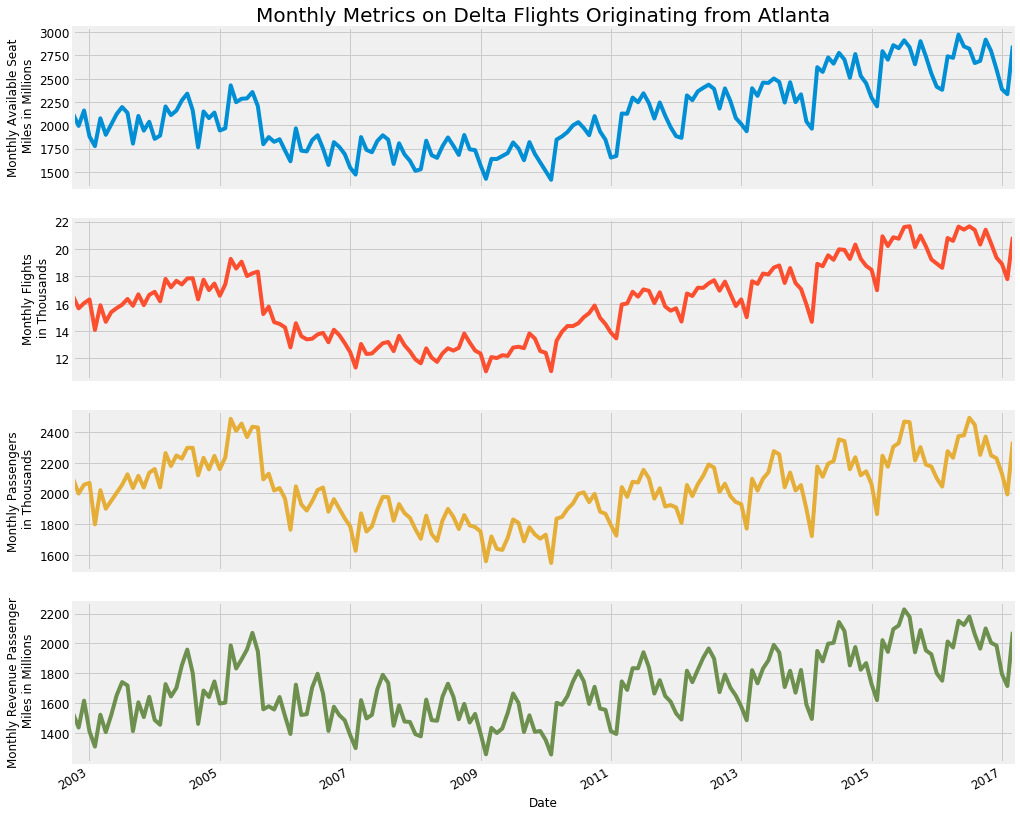

In [9]:
delta_atl_scaled = delta_atl.divide(1000)
axes = delta_atl_scaled.plot(subplots=True, figsize=(15, 15), grid=True, fontsize=12, legend=False)
axes[0].set_ylabel('Monthly Available Seat\n Miles in Millions', fontsize=12)
axes[0].set_title('Monthly Metrics on Delta Flights Originating from Atlanta', fontsize=20)
axes[1].set_ylabel('Monthly Flights\n in Thousands', fontsize=12)
axes[2].set_ylabel('Monthly Passengers\n in Thousands', fontsize=12)
axes[3].set_ylabel('Monthly Revenue Passenger\n Miles in Millions', fontsize=12)
plt.show()

Time series shows clear evidence of seasonality and trends. The long-term trend is upward growth, but there are also some shorter-term economic trends at play. The effects of the 2007-2008 financial crisis are quite evident. Let's quantify the degree of stationarity with charts and the Dickey-Fuller test.

In [10]:
def test_stationarity(time_series):
    
    """Takes a single pandas Series and produces evidence that can be used
    to analyze stationarity or lack thereof in the time series. Will not work
    with pandas DataFrame, numpy array, or any other data format.
    """

    # Check for upward or downward sloping trends in the moving average.
    # Trends indicate non-stationarity which should be taken into account
    # when building ARIMA model.
    
    moving_average = time_series.rolling(window=12).mean()
    moving_std = time_series.rolling(window=12).std()
    
    if time_series.name != None:
        name = time_series.name.split('_')[0]
    else:
        name = 'Series'
        
    plt.plot(time_series, color='blue', label='Monthly {}'.format(name))
    plt.plot(moving_average, color='red', label='Moving Average')
    plt.plot(moving_std, color='black', label='Moving Std.')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # The greater the p-value in the test output, the stronger the
    # non-stationarity of the time series. Series with p-value less
    # than 0.05 can generally be considered at least weakly stationary
    
    print 'Results of Dickey-Fuller Test:'
    test = adfuller(time_series, autolag='AIC')
    test_output = pd.Series(test[0:4], index=['Test Statistic', 'p-value',
                         '#Lags Used', 'Number of Observations Used'])
    for key, value in test[4].items():
        test_output['Critical Value {}'.format(key)] = value
    print test_output

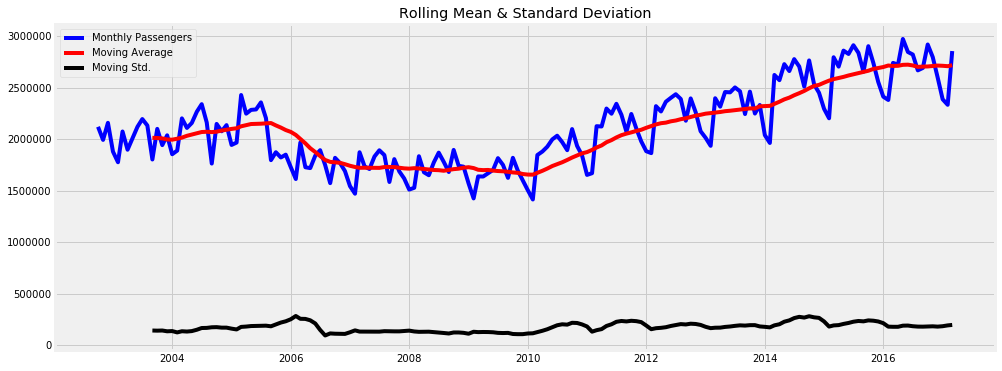

Results of Dickey-Fuller Test:
Test Statistic                  -0.242458
p-value                          0.933268
#Lags Used                      12.000000
Number of Observations Used    161.000000
Critical Value 5%               -2.879665
Critical Value 1%               -3.471633
Critical Value 10%              -2.576434
dtype: float64


In [11]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
test_stationarity(delta_atl['Passengers_Domestic'])

Upward trend is obvious in the moving average. P-value of 0.933268 indicates very strong degree of non-stationarity.

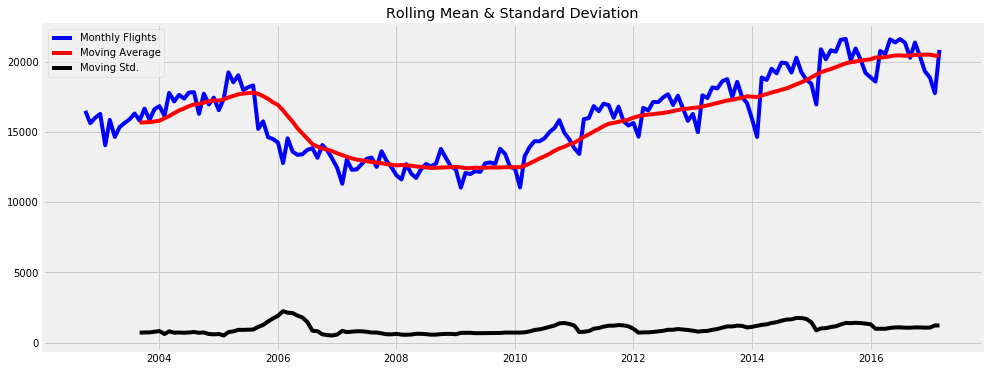

Results of Dickey-Fuller Test:
Test Statistic                  -1.241472
p-value                          0.655506
#Lags Used                      12.000000
Number of Observations Used    161.000000
Critical Value 5%               -2.879665
Critical Value 1%               -3.471633
Critical Value 10%              -2.576434
dtype: float64


In [12]:
test_stationarity(delta_atl['Flights_Domestic'])

A bit better, but still highly non-stationary.

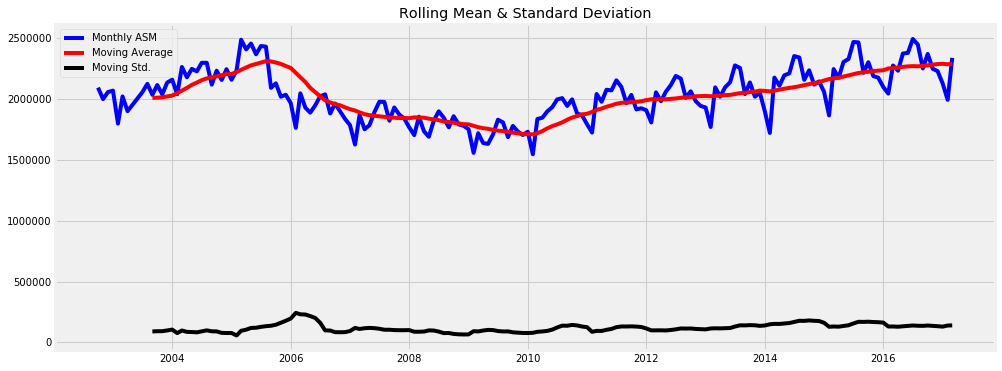

Results of Dickey-Fuller Test:
Test Statistic                  -1.787878
p-value                          0.386496
#Lags Used                      12.000000
Number of Observations Used    161.000000
Critical Value 5%               -2.879665
Critical Value 1%               -3.471633
Critical Value 10%              -2.576434
dtype: float64


In [13]:
test_stationarity(delta_atl['ASM_Domestic'])

This is as stationary as these time series get without transformation.

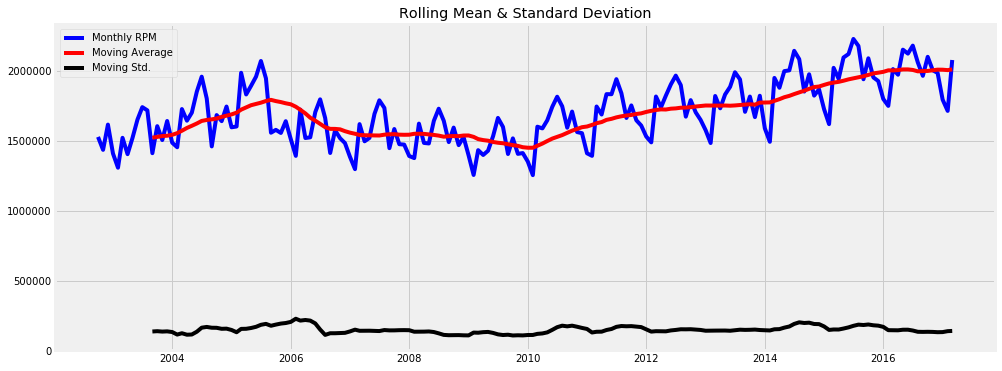

Results of Dickey-Fuller Test:
Test Statistic                  -0.743391
p-value                          0.835188
#Lags Used                      12.000000
Number of Observations Used    161.000000
Critical Value 5%               -2.879665
Critical Value 1%               -3.471633
Critical Value 10%              -2.576434
dtype: float64


In [14]:
test_stationarity(delta_atl['RPM_Domestic'])

Also not very good. The series shows sharp peaks and valleys - strong evidence of seasonality. Let's make a function to remove seasonality and another to add it back in later.

In [15]:
def remove_seasonality(series, lag=12):
    
    difference = list()
    for i in xrange(lag, len(series)):
        value = series[i] - series[i - lag]
        difference.append(value)
    return np.array(difference)

def add_seasonality(history, pred, lag=1):
    return pred + history[-lag]

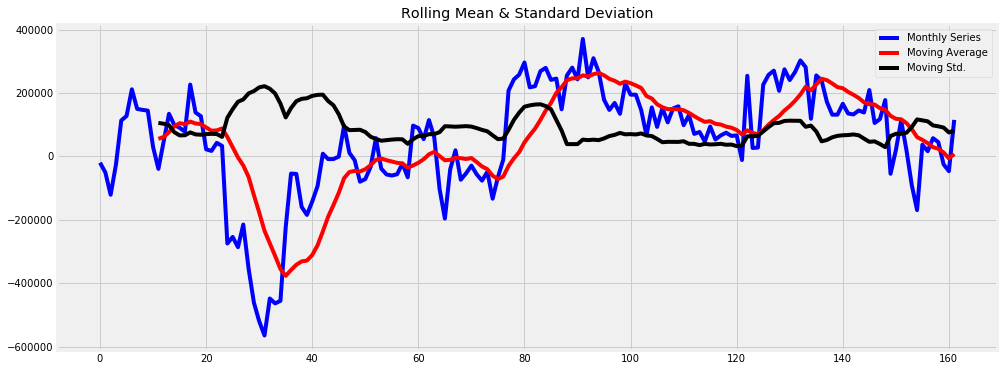

Results of Dickey-Fuller Test:
Test Statistic                  -2.186806
p-value                          0.211069
#Lags Used                      12.000000
Number of Observations Used    149.000000
Critical Value 5%               -2.881141
Critical Value 1%               -3.475018
Critical Value 10%              -2.577221
dtype: float64


In [16]:
passengers_deseasoned = remove_seasonality(delta_atl['Passengers_Domestic'])
passengers_deseasoned = pd.Series(passengers_deseasoned)
test_stationarity(passengers_deseasoned)

Much better, but still not quite stationary due to the long-term trend. The depth of the recession stands out much more.

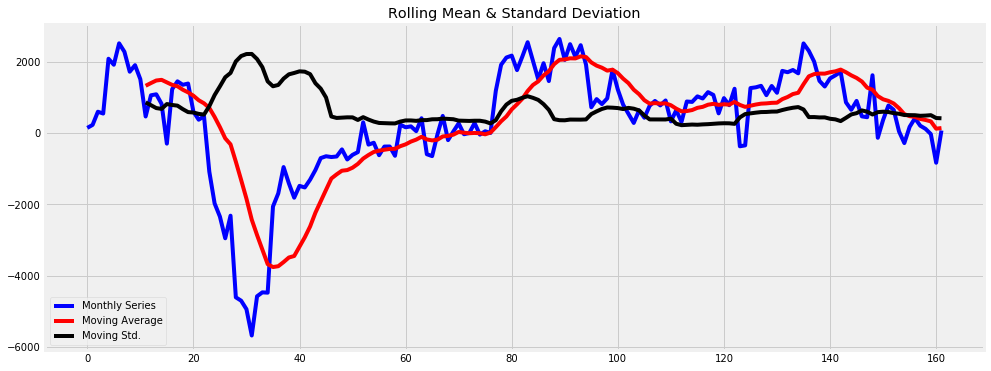

Results of Dickey-Fuller Test:
Test Statistic                  -2.477670
p-value                          0.121002
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value 5%               -2.879665
Critical Value 1%               -3.471633
Critical Value 10%              -2.576434
dtype: float64


In [17]:
flights_deseasoned = remove_seasonality(delta_atl['Flights_Domestic'])
flights_deseasoned = pd.Series(flights_deseasoned)
test_stationarity(flights_deseasoned)

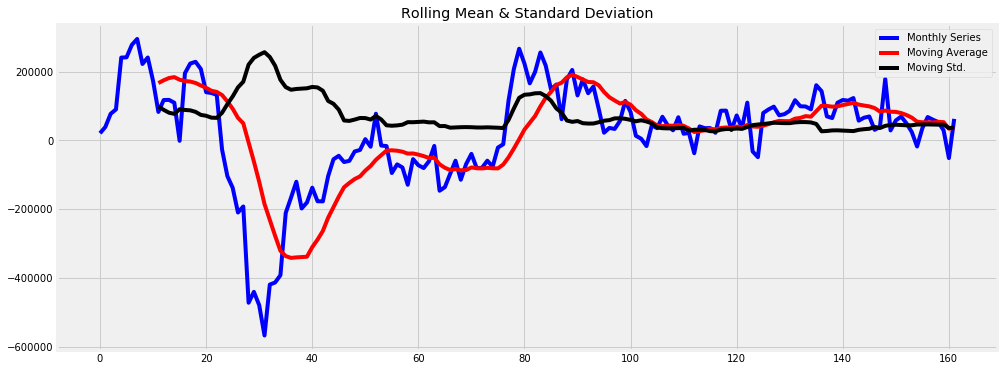

Results of Dickey-Fuller Test:
Test Statistic                  -2.704693
p-value                          0.073230
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value 5%               -2.879665
Critical Value 1%               -3.471633
Critical Value 10%              -2.576434
dtype: float64


In [18]:
asm_deseasoned = remove_seasonality(delta_atl['ASM_Domestic'])
asm_deseasoned = pd.Series(asm_deseasoned)
test_stationarity(asm_deseasoned)

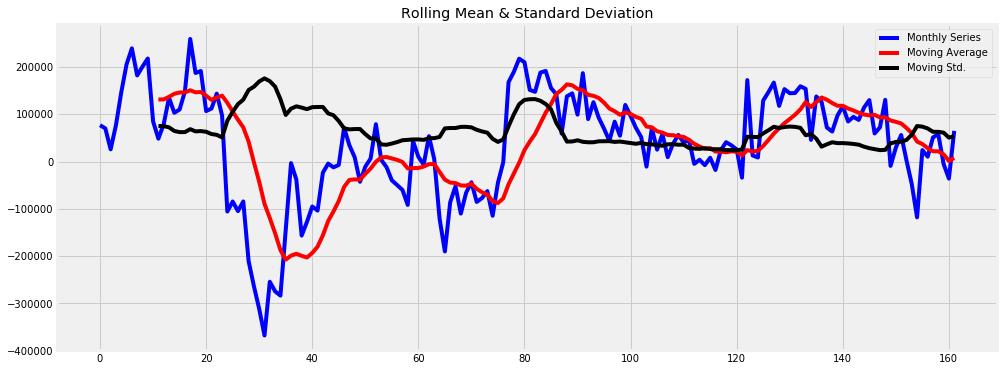

Results of Dickey-Fuller Test:
Test Statistic                  -2.732290
p-value                          0.068615
#Lags Used                      12.000000
Number of Observations Used    149.000000
Critical Value 5%               -2.881141
Critical Value 1%               -3.475018
Critical Value 10%              -2.577221
dtype: float64


In [19]:
rpm_deseasoned = remove_seasonality(delta_atl['RPM_Domestic'])
rpm_deseasoned = pd.Series(rpm_deseasoned)
test_stationarity(rpm_deseasoned)

ASM and RPM are looking really good. Let's try to difference out the seasonality and the trend and use ARIMA to make forecasts. Performance will be evaluated with RMSE and R_SQ. We're going to fit ARIMA with basic config. to the first 162 months in each set use the parameters to forecast the final 12.

In [20]:
def predict_final_year(time_series, order=(12,1,2), search=False):
    
    data = time_series.values
    train, test = data[:-12], data[-12:]
    differenced = remove_seasonality(train, lag=12)
    model = ARIMA(differenced, order=order)
    model_fit = model.fit(disp=0)
    forecast = model_fit.forecast(12)[0]
    history = [x for x in train]
    for pred in forecast:
        reverted = add_seasonality(history, pred, lag=12)
        history.append(reverted)
    preds = np.array(history[-12:])
    
    # Only to be used when called from grid_search function. 
    # Should not be activated manually in any other context.
    if search:
        return mean_squared_error(test, preds)
    
    print 'RMSE: ' + str(round(np.sqrt(mean_squared_error(test, preds)),3))
    print 'R_SQ: '+ str(round(r2_score(test, preds),3))
    
    return test, preds

In [21]:
passengers_test, passengers_pred = predict_final_year(delta_atl['Passengers_Domestic'])

RMSE: 71966.753
R_SQ: 0.856


In [22]:
flights_test, flights_pred = predict_final_year(delta_atl['Flights_Domestic'])

RMSE: 795.673
R_SQ: 0.537


In [23]:
asm_test, asm_pred = predict_final_year(delta_atl['ASM_Domestic'])

RMSE: 29733.302
R_SQ: 0.951


In [24]:
rpm_test, rpm_pred = predict_final_year(delta_atl['RPM_Domestic'])

RMSE: 47057.477
R_SQ: 0.877


Most of the results looking great, with the exception of the flight dataset perhaps. Now finally for a pretty picture:\*

\* My matplotlib skills aren't the best, so this might be a bit messy, but bear with me. It get's the job done.

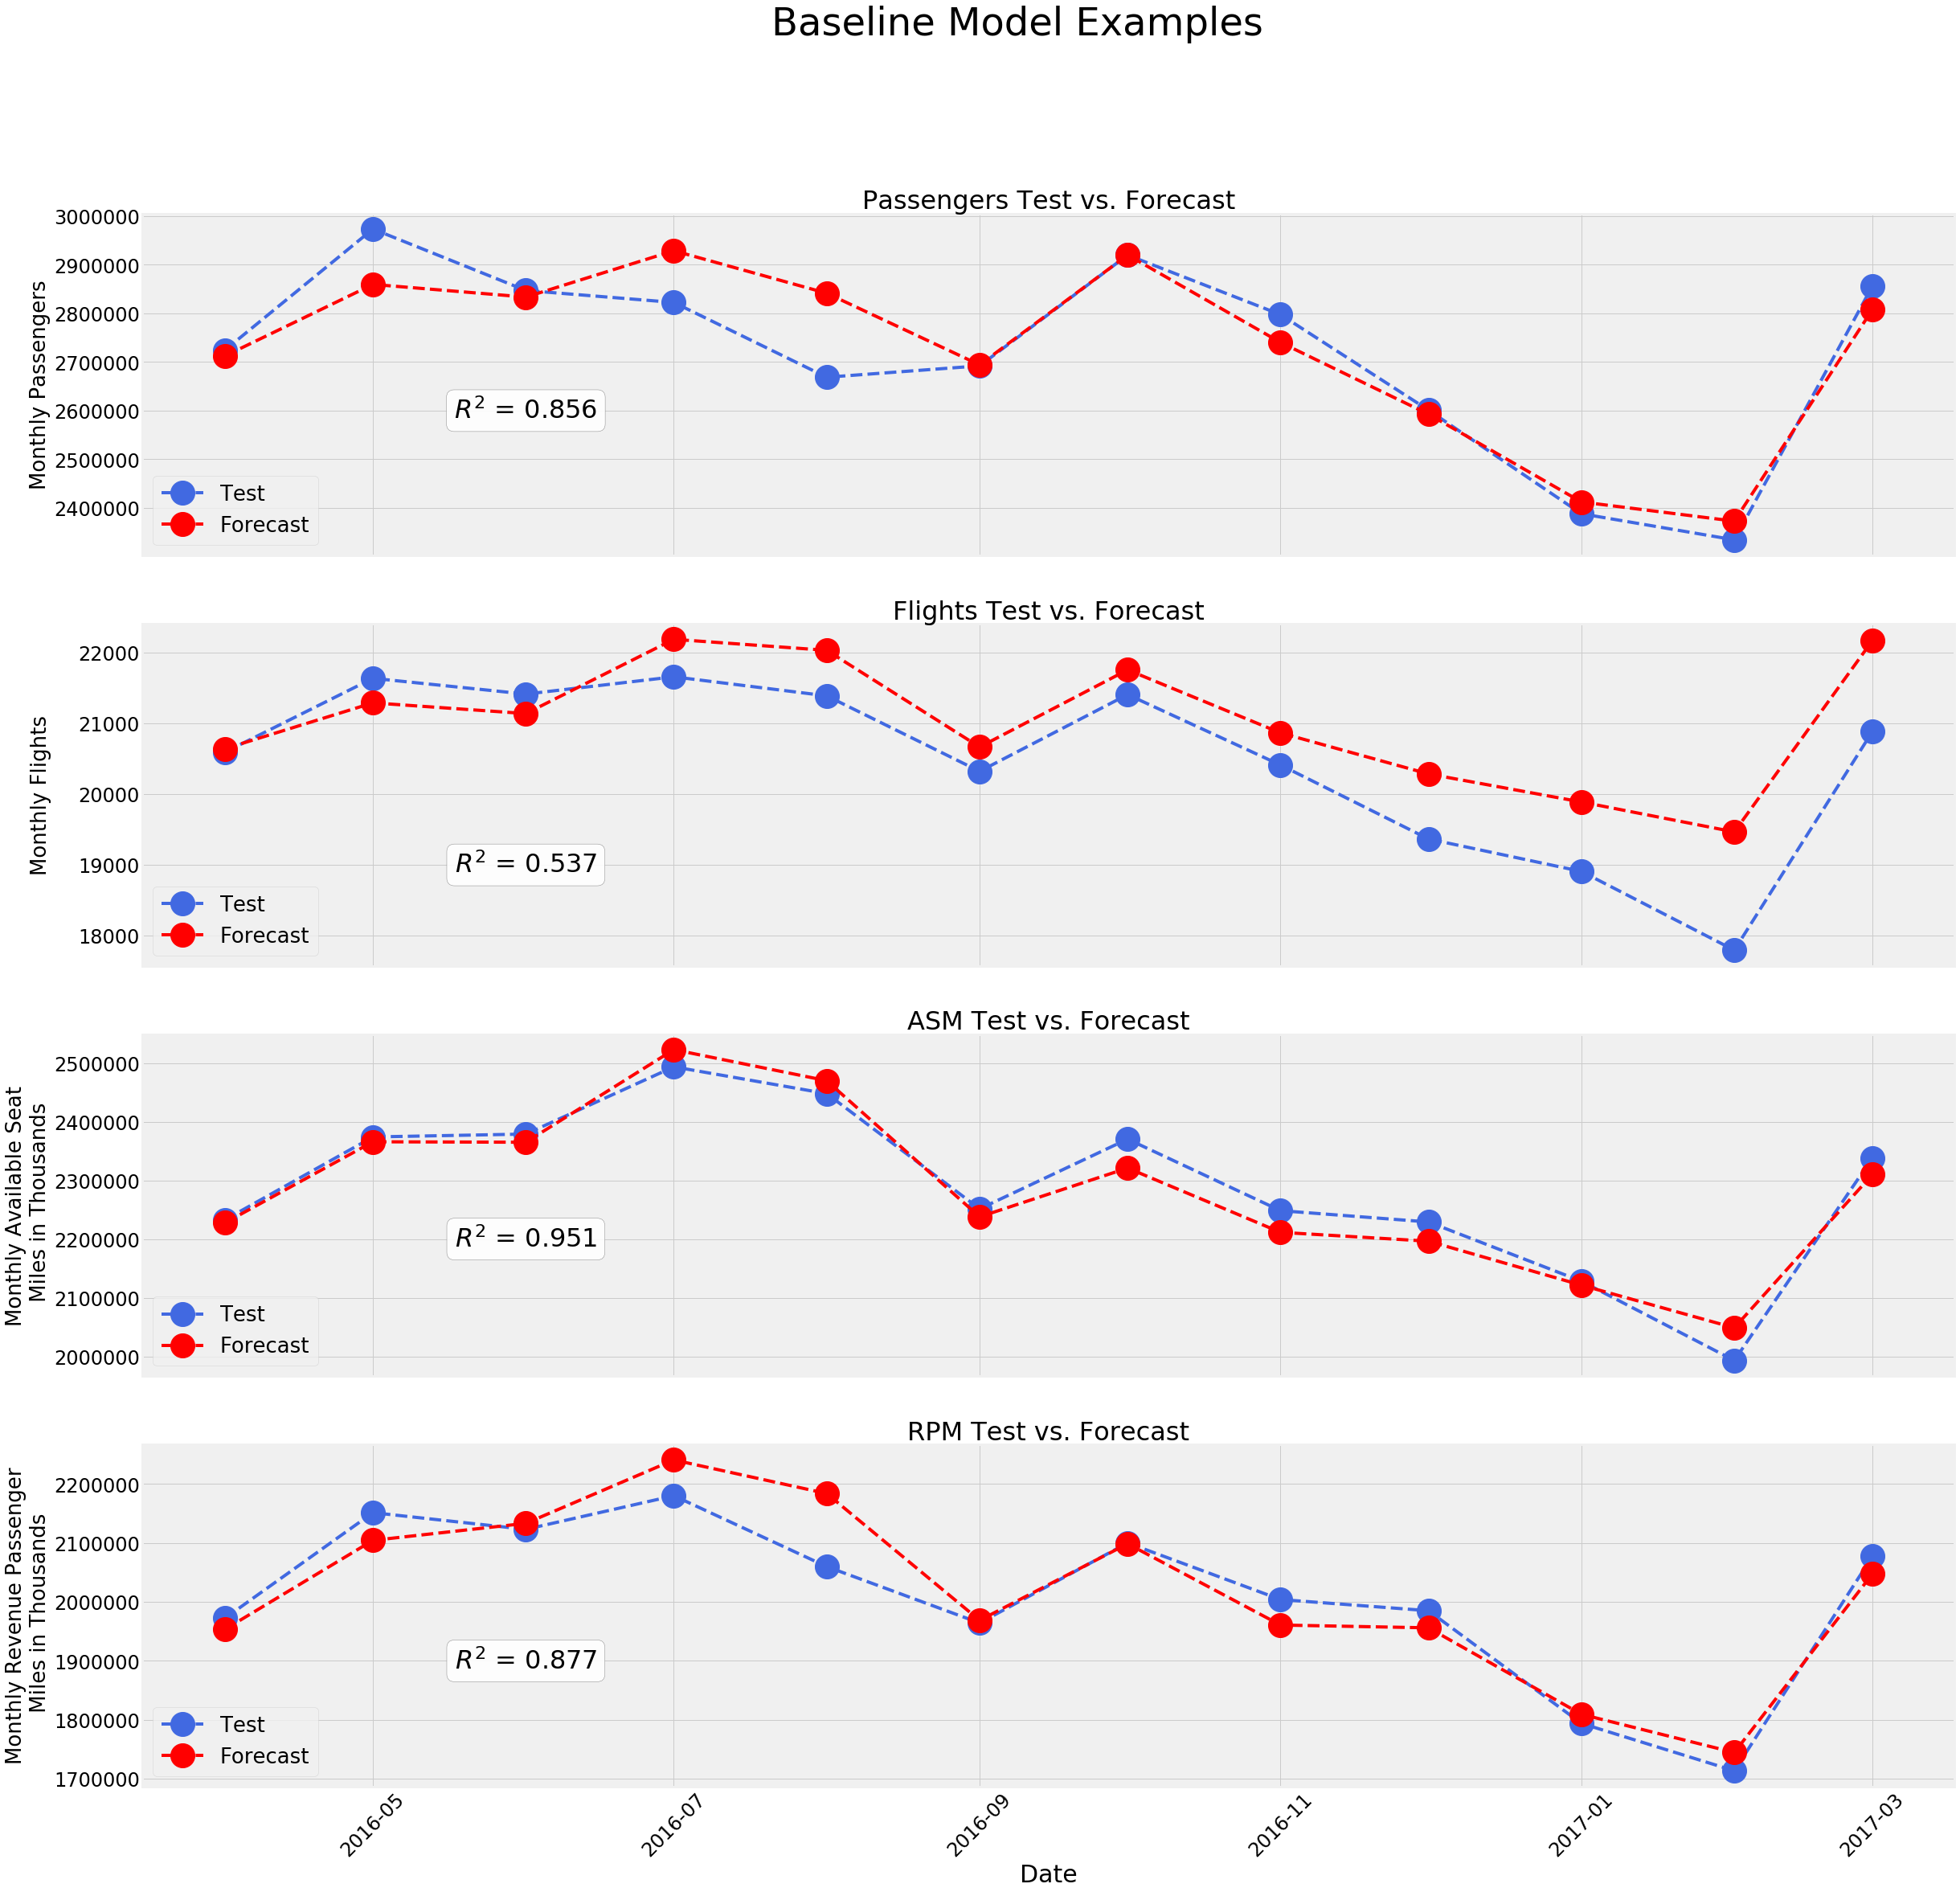

In [25]:
dtrange = pd.date_range("2016-04", "2017-03-01", freq='MS')
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

fig, axarr = plt.subplots(4, sharex=True, figsize=(36,36))

axarr[0].grid(True)
axarr[0].set_title('Passengers Test vs. Forecast', fontsize=32)
axarr[0].plot(dtrange, passengers_test, 'o--', ms=30, color='#4169e1', label='Test', linewidth=4)
axarr[0].plot(dtrange, passengers_pred, 'o--', ms=30, color='red', label='Forecast', linewidth=4)
axarr[0].legend(loc='lower left', fontsize=26)
axarr[0].set_ylabel('Monthly Passengers', fontsize=26)
axarr[0].tick_params(axis='y', labelsize=24)
axarr[0].text('2016-06-01', 2600000, '$ R^2 $ = 0.856', ha='center', va='center', bbox=bbox_props, size=32)


axarr[1].grid(True)
axarr[1].set_title('Flights Test vs. Forecast', fontsize=32)
axarr[1].plot(dtrange, flights_test, 'o--', ms=30, color='#4169e1', label='Test', linewidth=4)
axarr[1].plot(dtrange, flights_pred, 'o--', ms=30, color='red', label='Forecast', linewidth=4)
axarr[1].legend(loc='lower left', fontsize=26)
axarr[1].set_ylabel('Monthly Flights\n', fontsize=26)
axarr[1].text('2016-06-01', 19000, '$ R^2 $ = 0.537', ha='center', va='center', bbox=bbox_props, size=32)
axarr[1].tick_params(axis='y', labelsize=24)


axarr[2].grid(True)
axarr[2].set_title('ASM Test vs. Forecast', fontsize=32)
axarr[2].plot(dtrange, asm_test , 'o--', ms=30, color='#4169e1', label='Test', linewidth=4)
axarr[2].plot(dtrange, asm_pred, 'o--', ms=30, color='red', label='Forecast', linewidth=4)
axarr[2].legend(loc='lower left', fontsize=26)
axarr[2].set_ylabel('Monthly Available Seat\n Miles in Thousands', fontsize=26)
axarr[2].text('2016-06-01', 2200000, '$ R^2 $ = 0.951', ha='center', va='center', bbox=bbox_props, size=32)
axarr[2].tick_params(axis='y', labelsize=24)



axarr[3].grid(True)
axarr[3].set_title('RPM Test vs. Forecast', fontsize=32)
axarr[3].plot(dtrange, rpm_test , 'o--', ms=30, color='#4169e1', label='Test', linewidth=4)
axarr[3].plot(dtrange, rpm_pred, 'o--', ms=30, color='red', label='Forecast', linewidth=4)
axarr[3].legend(loc='lower left', fontsize=26)
axarr[3].set_ylabel('Monthly Revenue Passenger\n Miles in Thousands', fontsize=26)
axarr[3].text('2016-06-01', 1900000, '$ R^2 $ = 0.877', ha='center', va='center', bbox=bbox_props, size=32)
axarr[3].tick_params(axis='y', labelsize=24)
axarr[3].set_xlabel('Date', fontsize=30)

plt.setp(plt.xticks()[1], rotation=45, fontsize=24)
plt.suptitle('Baseline Model Examples', fontsize=48)
plt.show()

There we go! Now you can follow these steps to model any time series you'd like, changing settings and parameters as you see fit. Here's a grid-search function that will optimize the order of the ARIMA model. Note this is extremely expensive and will take time. Only use it if you have patience.

In [26]:
def grid_search(time_series, p_values=range(13), d_values=range(3), q_values=range(3)):
    
    """Takes lists of p, d, and q values and tests all possible combinations, searching
       for the one that optimizes ARIMA forecasts according RMSE.
    """
    
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    print 'Testing ARIMA: {}'.format(order)
                    mse = predict_final_year(time_series, order, search=True)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('MSE: {:.3f}\n'.format(mse))
                except:
                    continue
    print 'Best ARIMA: {}'.format(best_cfg)
    print 'Best RMSE: {}'.format(np.sqrt(best_score))